In [1]:
%pylab inline


from tqdm import trange

Populating the interactive namespace from numpy and matplotlib


In [14]:
def fetch(url):
    import requests,  gzip, os, hashlib, numpy
    fp = os.path.join("/tmp", hashlib.md5(url.encode('utf-8')).hexdigest())
    if os.path.isfile(fp):
        with open(fp, "rb") as f:
            dat = f.read()
    else:
        with open(fp, "wb") as f:
            dat = requests.get(url).content
            f.write(dat)
    return numpy.frombuffer(gzip.decompress(dat), dtype=numpy.uint8).copy()
X_train = fetch("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[0x10:].reshape((-1,28,28))
Y_train = fetch("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[8:]
X_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")[0x10:].reshape((-1,28,28))
Y_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")[8:]

(<matplotlib.image.AxesImage at 0x7fee544a2f70>, 0)

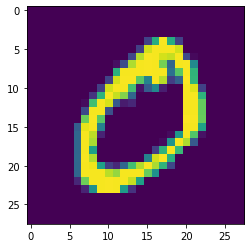

In [15]:
# from pylab import *
imshow(X_train[1]), Y_train[1]

In [18]:
import torch
import torch.nn as nn
class NeuralNet(torch.nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.l1 = nn.Linear(784,128, bias=False)
        self.act = nn.ReLU()
        self.l2 = nn.Linear(128,10, bias=False)
    def forward(self, x):
        x = self.l1(x)
        x = self.act(x)
        x = self.l2(x)
        return x


loss 0.03 accuracy 0.98: 100%|██████████| 1000/1000 [00:03<00:00, 311.51it/s]


Percent correct:  0.9509


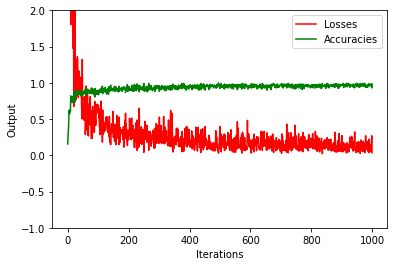

In [28]:
# Training steps
BS = 128
model = NeuralNet()
loss_function= nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters())
losses, accuracies = [], []

for i in (t := trange(1000)):
    samp = np.random.randint(0, X_train.shape[0], size=(BS))
    X = torch.tensor(X_train[samp].reshape(-1, 28*28)).float()
    Y = torch.tensor(Y_train[samp]).long()
    optim.zero_grad()
    out = model(X)
    cat = torch.argmax(out, dim=1)
    accuracy = (cat == Y).float().mean()
    loss = loss_function(out, Y)
    loss.backward()
    optim.step()
    loss, accuracy = loss.item(), accuracy.item()
    losses.append(loss)
    accuracies.append(accuracy)
    t.set_description("loss %.2f accuracy %.2f" % (loss, accuracy))
    
fig, ax = plt.subplots()
plt.ylim(-1,2)
ax.plot(losses, label="Losses", color='r')
ax.plot(accuracies, label="Accuracies", color='g')
ax.set_xlabel("Iterations")
ax.set_ylabel("Output")
ax.legend()
# find the first 5% of iterations that contribute to the highest learning curve -> find the rate of change for those points
# Find rate of accuracy change for first 5% of points
# Evaluation
results = torch.argmax(model(torch.tensor(X_test.reshape((-1, 28*28))).float()), dim=1).numpy()
print("Percent correct: ", (Y_test == results).mean())
# return trained model


In [8]:
# Calculating the derivative 
ri = int(0.1*100)
dx = 1
y = accuracies[0:ri]

dy = np.diff(y)/dx

print(dy)

[0.140625  0.0703125 0.15625   0.0234375 0.0625    0.109375  0.046875
 0.0234375 0.015625 ]
